# **Paso 1: Importar librerías a utilizar**

In [9]:
import imaplib
import email
import yaml

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from email.header import decode_header

from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from matplotlib.colors import LinearSegmentedColormap

# **Paso 2: Acceder a Gmail**

In [10]:
with open('credentials.yaml') as f:
  content = f.read()
my_credentials = yaml.load(content, Loader = yaml.FullLoader)
user, password = my_credentials['user'], my_credentials['password']

imap_url = 'imap.gmail.com'
my_mail = imaplib.IMAP4_SSL(imap_url)
my_mail.login(user, password)



('OK', [b'jairomt0198@gmail.com authenticated (Success)'])

In [11]:
my_mail.select('Inbox')

('OK', [b'126'])

In [12]:
total_emails = int(my_mail.select('Inbox')[1][0])
total_emails

126

# **Paso 3: Extraer información requerida de los correos**

In [13]:
email_df = pd.DataFrame(columns = ['Date', 'From', 'Subject'], index = range(total_emails, 0, -1))

for i in tqdm(range(total_emails, 0, -1)):
  data = my_mail.fetch(str(i), '(UID RFC822)')
  for response_part in data:
    arr = response_part[0]
    if isinstance(arr, tuple):
      try: msg = email.message_from_string(str(arr[1], 'utf-8'))
      except: msg = email.message_from_string(str(arr[1], 'latin-1'))
      new_row = pd.Series({'Date': msg['Date'], 'From': msg['from'], 'Subject': msg['subject']})
  email_df = email_df.append(new_row, ignore_index=True)

email_df = email_df.dropna(how='all').reset_index(drop=True)
email_df.head()

  0%|          | 0/126 [00:00<?, ?it/s]C:\Users\JAIRO\AppData\Local\Temp\ipykernel_12244\2765324046.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  email_df = email_df.append(new_row, ignore_index=True)
  1%|          | 1/126 [00:00<00:45,  2.76it/s]C:\Users\JAIRO\AppData\Local\Temp\ipykernel_12244\2765324046.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  email_df = email_df.append(new_row, ignore_index=True)
  2%|▏         | 2/126 [00:00<00:56,  2.18it/s]C:\Users\JAIRO\AppData\Local\Temp\ipykernel_12244\2765324046.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  email_df = email_df.append(new_row, ignore_index=True)
  2%|▏         | 3/126 [00:01<00:44,  2.78it/s]C:\Users\JAIRO\AppData\Local\Temp\ipykernel_12

,Date,From,Subject
0,"Tue, 03 Jan 2023 18:46:50 GMT",Google <no-reply@accounts.google.com>,Alerta de seguridad
1,"Tue, 03 Jan 2023 13:09:34 +0000","""SCRUMstudy"" <support@scrumstudycertifications...",=?UTF-8?Q?=F0=9F=93=A3_Jairo=2C_Join_the_Free_...
2,"Sat, 31 Dec 2022 17:13:51 +0000",Twitter <verify@twitter.com>,=?UTF-8?Q?Nuevo_inicio_de_sesi=C3=B3n_de_Twitt...
3,"Sat, 31 Dec 2022 17:11:03 GMT",Google <no-reply@accounts.google.com>,Alerta de seguridad
4,"Sat, 31 Dec 2022 17:11:03 GMT",Google <no-reply@accounts.google.com>,Tu cuenta de Google se ha recuperado correctam...


In [14]:
email_df.to_csv('email_df.csv', index=False, encoding='utf-8')

In [15]:
email_df = pd.read_csv('email_df.csv').fillna('')
email_df.head(10)

,Date,From,Subject
0,"Tue, 03 Jan 2023 18:46:50 GMT",Google <no-reply@accounts.google.com>,Alerta de seguridad
1,"Tue, 03 Jan 2023 13:09:34 +0000","""SCRUMstudy"" <support@scrumstudycertifications...",=?UTF-8?Q?=F0=9F=93=A3_Jairo=2C_Join_the_Free_...
2,"Sat, 31 Dec 2022 17:13:51 +0000",Twitter <verify@twitter.com>,=?UTF-8?Q?Nuevo_inicio_de_sesi=C3=B3n_de_Twitt...
3,"Sat, 31 Dec 2022 17:11:03 GMT",Google <no-reply@accounts.google.com>,Alerta de seguridad
4,"Sat, 31 Dec 2022 17:11:03 GMT",Google <no-reply@accounts.google.com>,Tu cuenta de Google se ha recuperado correctam...
5,"Sat, 31 Dec 2022 17:09:07 +0000",Google <noreply@google.com>,=?UTF-8?Q?C=C3=B3digo_de_verificaci=C3=B3n_de_...
6,"Sat, 31 Dec 2022 17:06:58 +0000",Twitter <verify@twitter.com>,473514 is your Twitter verification code
7,"Wed, 28 Dec 2022 16:37:25 GMT",Google <no-reply@accounts.google.com>,Alerta de seguridad
8,"Wed, 28 Dec 2022 16:36:43 GMT",Google <no-reply@accounts.google.com>,Alerta de seguridad
9,"Wed, 28 Dec 2022 16:01:59 GMT",Google <no-reply@accounts.google.com>,Alerta de seguridad


# **Paso 4: Limpieza de Datos**

In [16]:
def extraer_correo_from(texto):
  correo = texto.split('<')[-1].split('>')[0]
  return correo 

In [17]:
def obtener_nombre_from(texto):
  text, encoding = decode_header(texto)[0]
  if not encoding and isinstance(text, str):
    text = ' '.join(text.split(' ')[:-1])
  else:
    text = text.decode('utf-8', errors='ignore')
  
  text = text.replace('"','')
  return text

In [18]:
def limpiar_subject(texto): 
  if texto:
    text, encoding = decode_header(texto)[0]
    try:
      text = text.decode('utf-8', errors='ignore')
    except:
      pass
  else: text = x
  return text

In [19]:
email_df['Email'] = email_df['From'].apply(lambda x: extraer_correo_from(x))
email_df['Name'] = email_df['From'].apply(lambda x: obtener_nombre_from(x))
email_df['Subject'] = email_df['Subject'].apply(lambda x: limpiar_subject(x))
email_df = email_df.drop(columns=['From'])
email_df.head(10)

,Date,Subject,Email,Name
0,"Tue, 03 Jan 2023 18:46:50 GMT",Alerta de seguridad,no-reply@accounts.google.com,Google
1,"Tue, 03 Jan 2023 13:09:34 +0000","📣 Jairo, Join the Free Scrum Fundamentals Webi...",support@scrumstudycertifications.org,SCRUMstudy
2,"Sat, 31 Dec 2022 17:13:51 +0000",Nuevo inicio de sesión de Twitter desde Chrome...,verify@twitter.com,Twitter
3,"Sat, 31 Dec 2022 17:11:03 GMT",Alerta de seguridad,no-reply@accounts.google.com,Google
4,"Sat, 31 Dec 2022 17:11:03 GMT",Tu cuenta de Google se ha recuperado correctam...,no-reply@accounts.google.com,Google
5,"Sat, 31 Dec 2022 17:09:07 +0000",Código de verificación de Google,noreply@google.com,Google
6,"Sat, 31 Dec 2022 17:06:58 +0000",473514 is your Twitter verification code,verify@twitter.com,Twitter
7,"Wed, 28 Dec 2022 16:37:25 GMT",Alerta de seguridad,no-reply@accounts.google.com,Google
8,"Wed, 28 Dec 2022 16:36:43 GMT",Alerta de seguridad,no-reply@accounts.google.com,Google
9,"Wed, 28 Dec 2022 16:01:59 GMT",Alerta de seguridad,no-reply@accounts.google.com,Google


# **Paso 5: Manipulación de Datos**

In [20]:
email_df['Date'] = pd.to_datetime(email_df['Date'])
email_df['Hour'] = email_df['Date'].apply(lambda x: str(x.hour)+'h-'+str(x.hour+1)+'h')
email_df['Weekday'] = email_df['Date'].apply(lambda x: x.strftime('%A'))
email_df.head(10)

,Date,Subject,Email,Name,Hour,Weekday
0,2023-01-03 18:46:50+00:00,Alerta de seguridad,no-reply@accounts.google.com,Google,18h-19h,Tuesday
1,2023-01-03 13:09:34+00:00,"📣 Jairo, Join the Free Scrum Fundamentals Webi...",support@scrumstudycertifications.org,SCRUMstudy,13h-14h,Tuesday
2,2022-12-31 17:13:51+00:00,Nuevo inicio de sesión de Twitter desde Chrome...,verify@twitter.com,Twitter,17h-18h,Saturday
3,2022-12-31 17:11:03+00:00,Alerta de seguridad,no-reply@accounts.google.com,Google,17h-18h,Saturday
4,2022-12-31 17:11:03+00:00,Tu cuenta de Google se ha recuperado correctam...,no-reply@accounts.google.com,Google,17h-18h,Saturday
5,2022-12-31 17:09:07+00:00,Código de verificación de Google,noreply@google.com,Google,17h-18h,Saturday
6,2022-12-31 17:06:58+00:00,473514 is your Twitter verification code,verify@twitter.com,Twitter,17h-18h,Saturday
7,2022-12-28 16:37:25+00:00,Alerta de seguridad,no-reply@accounts.google.com,Google,16h-17h,Wednesday
8,2022-12-28 16:36:43+00:00,Alerta de seguridad,no-reply@accounts.google.com,Google,16h-17h,Wednesday
9,2022-12-28 16:01:59+00:00,Alerta de seguridad,no-reply@accounts.google.com,Google,16h-17h,Wednesday


In [21]:
email_df.to_csv('email_df_final.csv', quotechar='"', sep='|', index=False, encoding='utf-8')

# **Paso 6: Generando el Word Cloud de los Subjects**

In [22]:
def interpolar_256(num):
  return np.interp(x=num, xp=[0,255], fp=[0,1])

#Colores en RGB de los componentes del logo de Gmail: rojo (187, 0, 27), verde (52, 168, 83), azul claro (66, 133, 244),  naranja (234, 67, 53), amarillo (251, 188, 5)

cdict = {'red': ((0, interpolar_256(187), interpolar_256(187)),
                 (1/4, interpolar_256(52), interpolar_256(52)),
                 (2/4, interpolar_256(66), interpolar_256(66)),
                 (3/4, interpolar_256(234), interpolar_256(234)),
                 (1, interpolar_256(251), interpolar_256(251))),
         'green': ((0, interpolar_256(0), interpolar_256(0)),
                   (1/4, interpolar_256(168), interpolar_256(168)),
                   (2/4, interpolar_256(133), interpolar_256(133)),
                   (3/4, interpolar_256(67), interpolar_256(67)),
                   (1, interpolar_256(188), interpolar_256(188))),
         'blue': ((0, interpolar_256(27), interpolar_256(27)),
                  (1/4, interpolar_256(83), interpolar_256(83)),
                  (2/4, interpolar_256(244), interpolar_256(244)),
                  (3/4, interpolar_256(53), interpolar_256(53)),
                  (1, interpolar_256(5), interpolar_256(5)))}   

gmail = LinearSegmentedColormap('gmail', segmentdata=cdict)

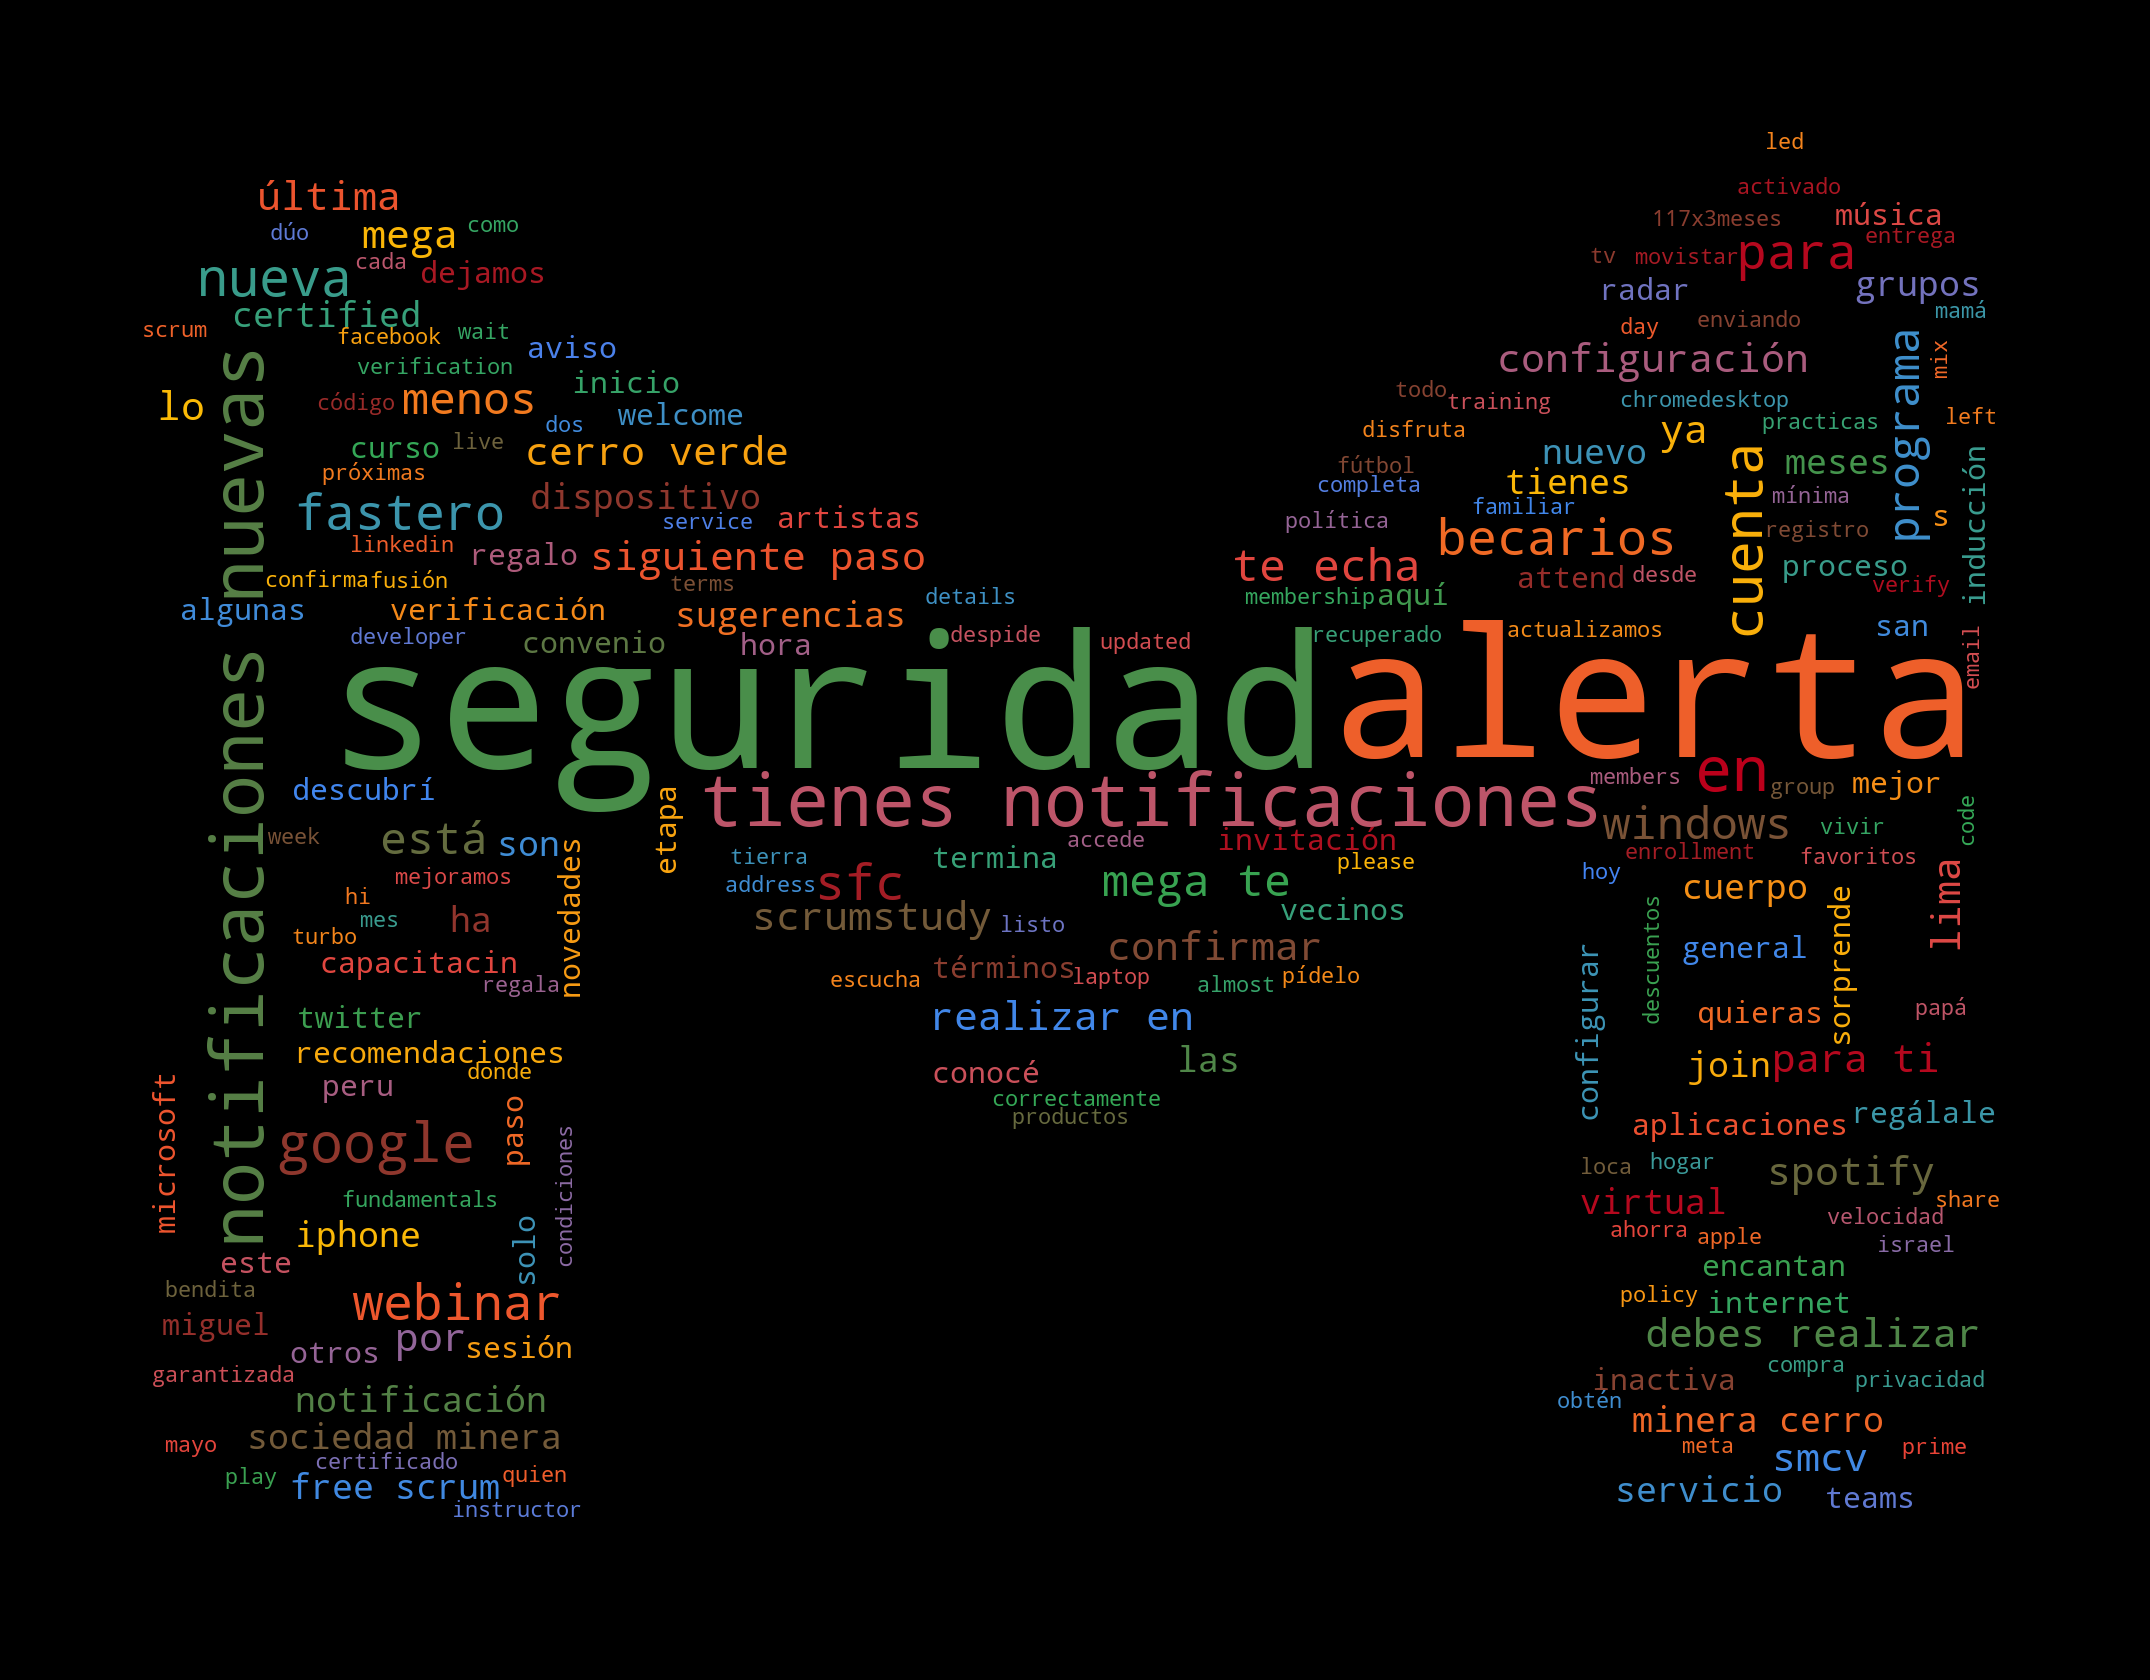

In [23]:
total_subjects = ' '
stopwords = STOPWORDS.update(['jairo', 'la', 'de', 'es', 'con', 'y', 'el', 'del', 'tu', 'más', 'al', 'un', 'se', 'tus', 'que', 'ha'
                              'quien'])
logo = np.array(Image.open('gmail.jpg'))

for mensaje in email_df['Subject'].values:
  subjects = str(mensaje).lower().split()
  for subject in subjects:
    total_subjects = total_subjects + subject + ' '

wordcloud = WordCloud(scale=2.5, width=1000, height=800,
                      background_color='black', mask=logo,
                      colormap= gmail, stopwords=stopwords,
                      min_font_size=6).generate(total_subjects)
wordcloud.to_image()             
    
